In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatSlider
import pandas as pd
import sklearn
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
import numpy as np
import seaborn as sns
import shap
import matplotlib
import scipy.stats as st
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
import pingouin as pg
from OLS_LR_DiagnosticPlots.ModelDiagnostics import Plot
import numpy as np
from scipy import linalg
import scipy
from sklearn.utils import check_array, as_float_array
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn import datasets
from bokeh.plotting import figure, show, output_notebook
from IPython.display import display, clear_output
from scipy.stats import moment
import holoviews as hv
from holoviews import dim, opts
import matplotlib.cm as cm
from scipy import stats
from sklearn.preprocessing import StandardScaler
output_notebook()

Loading BokehJS ...

In [2]:
#from k_means_constrained import KMeansConstrained
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import rpy2
import rpy2.robjects as ro
import os
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
import time
import random
import time
from numpy.random import seed
from scipy.stats import f
from PIL import Image
#hv.extension('matplotlib')
import lux

In [3]:
import rpy2
import rpy2.robjects as ro
import os
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr

In [4]:
wd = os.getcwd()

if (os.defpath==".;C:\\bin"):
    os.environ['R_HOME'] = 'C:/Users/User/Documents/R/R-4.1.2'
    os.environ['R_LIBS'] = 'C:/Users/User/Documents/R/R-4.1.2/library'
    from OLS_LR_DiagnosticPlots.ModelDiagnostics import Plot
else:
    os.environ['R_HOME'] = '/mnt/distvol/R/4.0.5/lib64/R/'

pandas2ri.activate()

base = importr('base')
grdevices = importr('grDevices')
print(base._libPaths())

#urbnmapr = importr('urbnmapr')
dplyr = importr('dplyr')
tidyverse = importr('tidyverse')


[1] "C:/Users/User/Documents/R/R-4.1.2/library"



In [5]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

def f_test(x, y, alt="two_sided"):
    """
    Calculates the F-test.
    :param x: The first group of data
    :param y: The second group of data
    :param alt: The alternative hypothesis, one of "two_sided" (default), "greater" or "less"
    :return: a tuple with the F statistic value and the p-value.
    """
    df1 = len(x) - 1
    df2 = len(y) - 1
    f = x.var() / y.var()
    if alt == "greater":
        p = 1.0 - st.f.cdf(f, df1, df2)
    elif alt == "less":
        p = st.f.cdf(f, df1, df2)
    else:
        # two-sided by default
        # Crawley, the R book, p.355
        p = 2.0*(1.0 - st.f.cdf(f, df1, df2))
    return f, p

def whiten(X, method='zca'):
		"""
		Whitens the input matrix X using specified whitening method.
		Inputs:
			X:      Input data matrix with data examples along the first dimension
			method: Whitening method. Must be one of 'zca', 'zca_cor', 'pca',
					'pca_cor', or 'cholesky'.
		"""
		X = X.reshape((-1, np.prod(X.shape[1:])))
		X_centered = X - np.mean(X, axis=0)
		Sigma = np.dot(X_centered.T, X_centered) / X_centered.shape[0]
		W = None
		if method in ['zca', 'pca', 'cholesky']:
			U, Lambda, _ = np.linalg.svd(Sigma)
			if method == 'zca':
				W = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(Lambda + 1e-5)), U.T))
			elif method =='pca':
				W = np.dot(np.diag(1.0 / np.sqrt(Lambda + 1e-5)), U.T)
			elif method == 'cholesky':
				W = np.linalg.cholesky(np.dot(U, np.dot(np.diag(1.0 / (Lambda + 1e-5)), U.T))).T
		elif method in ['zca_cor', 'pca_cor']:
			V_sqrt = np.diag(np.std(X, axis=0))
			P = np.dot(np.dot(np.linalg.inv(V_sqrt), Sigma), np.linalg.inv(V_sqrt))
			G, Theta, _ = np.linalg.svd(P)
			if method == 'zca_cor':
				W = np.dot(np.dot(G, np.dot(np.diag(1.0 / np.sqrt(Theta + 1e-5)), G.T)), np.linalg.inv(V_sqrt))
			elif method == 'pca_cor':
				W = np.dot(np.dot(np.diag(1.0/np.sqrt(Theta + 1e-5)), G.T), np.linalg.inv(V_sqrt))
		else:
			raise Exception('Whitening method not found.')
		return np.dot(X_centered, W.T)

In [6]:
def read_data():
    df = pd.read_csv("https://raw.githubusercontent.com/thistleknot/Python-Stock/master/data/raw/states.csv").set_index('States')
    return(df)

In [7]:
#for i in range(0,len(scaled_bins.columns)):
#    plt.plot(scaled_bins.iloc[:,i])

In [8]:
#Laferriere Transform
print("scatterplot of transformed values w Z scores")

def laferriere_transform (data, method):
    
    dataFrame = pd.DataFrame()

    if(method=='mean'):
        df_scaled = pd.DataFrame(StandardScaler().fit_transform(data),columns=data.columns).set_index(data.index)
        for c in data.columns:
            lower_index_ = df_scaled[[c]].sort_values(kind="quicksort", by=c,ascending=False)[df_scaled[[c]].sort_values(kind="quicksort", by=c,ascending=False)<0].cumsum().dropna()
            lower_index_ = lower_index_/lower_index_.min()
            lower_index_ = abs(((lower_index_-.5)-.5))/2
            upper_index_ = df_scaled[[c]].sort_values(kind="quicksort", by=c,ascending=True)[df_scaled[[c]].sort_values(kind="quicksort", by=c,ascending=True)>=0].cumsum().dropna()            
            upper_index_ = upper_index_/upper_index_.max()/2+.5            
            together_index = pd.concat([lower_index_,upper_index_],axis=0)            
            together_index.columns = [c]
            together_index = together_index.sort_values(kind="quicksort", by=c,ascending=True)
            dataFrame = pd.concat([dataFrame,together_index],axis=1)            
                    
            plt.scatter(pd.concat([together_index,df_scaled[[c]]],axis=1).iloc[:,0],pd.concat([together_index,df_scaled[[c]]],axis=1).iloc[:,1])
            
           
    elif(method=='median'):
        df_scaled = pd.DataFrame((data-np.median(data,axis=0))/stats.median_abs_deviation(data),columns=data.columns).set_index(data.index)
        for c in data.columns:
            lower_index_ = df_scaled[[c]].sort_values(kind="quicksort", by=c,ascending=False)[df_scaled[[c]].sort_values(kind="quicksort", by=c,ascending=False)<0].cumsum().dropna()
            lower_index_ = lower_index_/lower_index_.min()
            lower_index_ = abs(((lower_index_-.5)-.5))/2
            upper_index_ = df_scaled[[c]].sort_values(kind="quicksort", by=c,ascending=True)[df_scaled[[c]].sort_values(kind="quicksort", by=c,ascending=True)>=0].cumsum().dropna()
            upper_index_ = upper_index_/upper_index_.max()/2+.5
            together_index = pd.concat([lower_index_,upper_index_],axis=0)
            together_index.columns = [c]
            together_index = together_index.sort_values(kind="quicksort", by=c,ascending=True)
            dataFrame = pd.concat([dataFrame,together_index],axis=1)
            
            plt.scatter(pd.concat([together_index,df_scaled[[c]]],axis=1).iloc[:,0],pd.concat([together_index,df_scaled[[c]]],axis=1).iloc[:,1])
            #plt.show()

    plt.show()
    return(dataFrame)        

scatterplot of transformed values w Z scores


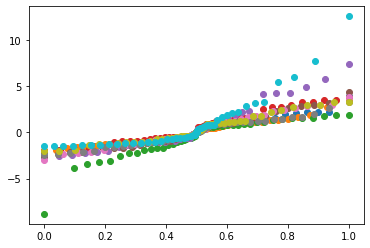

{1: 0.0, 2: 0.10714285714285712, 3: 0.29341976516634055, 4: 0.46241030658838883, 5: 0.5377277203348104, 6: 0.6976550960118169, 7: 0.8807237813884785, 8: 1.0}
{1: 0.0, 2: 0.09001782531194295, 3: 0.2577985739750446, 4: 0.44058229352347, 5: 0.5329636475662354, 6: 0.6827634011090573, 7: 0.8599815157116452, 8: 1.0}
{1: 0.0, 2: 0.15940263490344705, 3: 0.3348673524634543, 4: 0.4725681284966612, 5: 0.5446156451066712, 6: 0.7172367084321031, 7: 0.9027260413139182, 8: 1.0}
{1: 0.0, 2: 0.12164708490356901, 3: 0.3115440035468854, 4: 0.45812088967708564, 5: 0.552899430385657, 6: 0.7157881221402558, 7: 0.9022317676720515, 8: 1.0}
{1: 0.0, 2: 0.11169992302682215, 3: 0.301794067144295, 4: 0.46382260643022083, 5: 0.5222360543007885, 6: 0.6261248443891161, 7: 0.8383514138360306, 8: 1.0}
{1: 0.0, 2: 0.10403050108932459, 3: 0.295479302832244, 4: 0.4601186153473735, 5: 0.5304707759824456, 6: 0.6728007181328546, 7: 0.8675942549371634, 8: 1.0}
{1: 0.0, 2: 0.1308178191489361, 3: 0.3255485372340424, 4: 0.46581

0.2513695534943986

In [9]:
data = laferriere_transform(read_data(),"median")
data

quantiles_7num = [0,.02,.09,.25,.5,.75,.91,.98,1]
q_labels = [1,2,3,4,5,6,7,8]

q_s_a_labels = pd.DataFrame()
for i in data.columns:
    q_s_a_labels = pd.concat([q_s_a_labels,(pd.qcut(data[i], quantiles_7num, labels=q_labels, retbins=False, precision=3, duplicates='raise'))],axis=1)
    
q_s_a_labels = q_s_a_labels.apply(lambda col:pd.Categorical(col).codes)

q_s_a_labels

scaled_bins = pd.DataFrame()

for i in data.columns:
    column = []
    dict_ = {}
    for b in q_labels:
        #print(b-1)
        #print(np.mean(q_s_a_labels[i]==(b-1)))
        column.append(np.mean(data[i][q_s_a_labels[i]==(b-1)]))
        entry = {b:np.mean(data[i][q_s_a_labels[i]==(b-1)])}
        dict_.update(entry)
    print(dict_)
    scaled_bins = pd.concat([scaled_bins,pd.DataFrame(column)],axis=1)

dict_
dict_.get(q_s_a_labels.iloc[:,1][0],0)

In [10]:
#method = 'mean'

In [11]:
data

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [12]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}


In [13]:
ro.r('''

f <- function(df) {
library(urbnmapr)
library(viridis)
library(hrbrthemes)
library(dplyr)
#print(df)
spatial_data <- left_join(get_urbn_map(map = "states", sf = TRUE),
                          statedata,
                          by = "state_name")

spatial_data <- spatial_data[spatial_data$state_name %in% df$States,] %>% left_join(df, by = c('state_name' = 'States'))
spatial_data$cluster <- factor(spatial_data$cluster)

print(paste("C:\\\\Users\\\\User\\\\Documents\\\\wiki\\\\wiki\\\\dev\\\\R\\\\","clusterMap",sep = "",".png"),width = 1200, height = 800, units = "px", pointsize = 12, quality = 90)
jpeg(paste("C:\\\\Users\\\\User\\\\Documents\\\\wiki\\\\wiki\\\\dev\\\\R\\\\","clusterMap",sep = "",".png"),width = 1200, height = 800, units = "px", pointsize = 12, quality = 90)

p <- ggplot() +
  geom_sf(spatial_data,
          mapping = aes(fill = cluster),
          color = "#ffffff", size = 0.25) + scale_fill_discrete() +
  geom_sf_text(data = get_urbn_labels(map = "states", sf = TRUE), 
               aes(label = state_abbv), 
               size = 3)
  labs(fill = "cluster")

plot(p)
dev.off() 

}

''')

r_f = ro.globalenv['f']

In [14]:
#df[['Poverty', 'White', 'Traf Deaths', 'University', 'Unemployed', 'Income', 'Population']]

In [15]:
'''
output_figure = widgets.Output()
 
# Create the default figure
fig = []  # Storing the figure in a singular list is a bit of a 
          # hack. We need it to properly mutate the current
          # figure in our callbacks.
#p = create_figure(
#    iris['feature_names'][0],
#    iris['feature_names'][1],
#    data)
#fig.append(p)
with output_figure:
    interact(derive_xnames,y=y)
    #interact(return_model_vars,x=x_,y=y,autoremove=autoremove)
    #show(fig)
    
app_layout = widgets.Layout(display='flex',
                flex_flow='row nowrap',
                align_items='center',
                border='none',
                width='100%',
                margin='5px 5px 5px 5px')
 
# The final app is just a box
app=widgets.Box([y, output_figure], layout=app_layout)
 
# Display the app
display(app)
'''

"\noutput_figure = widgets.Output()\n \n# Create the default figure\nfig = []  # Storing the figure in a singular list is a bit of a \n          # hack. We need it to properly mutate the current\n          # figure in our callbacks.\n#p = create_figure(\n#    iris['feature_names'][0],\n#    iris['feature_names'][1],\n#    data)\n#fig.append(p)\nwith output_figure:\n    interact(derive_xnames,y=y)\n    #interact(return_model_vars,x=x_,y=y,autoremove=autoremove)\n    #show(fig)\n    \napp_layout = widgets.Layout(display='flex',\n                flex_flow='row nowrap',\n                align_items='center',\n                border='none',\n                width='100%',\n                margin='5px 5px 5px 5px')\n \n# The final app is just a box\napp=widgets.Box([y, output_figure], layout=app_layout)\n \n# Display the app\ndisplay(app)\n"

In [16]:
def return_model_vars(x,y,autoremove):
    #print(x)
    names = [y,*x]
    print(names)
    
    shap.initjs()
    
    data = df[names].sort_values(kind="quicksort", by=names[0], ascending=True,key=abs).copy()
    
    loop=True
    
    removes = []
    if(autoremove):
        while(loop==True):

            x_names = data.columns[~data.columns.isin([item for item in [y,*removes]])]

            #x_scores = data[[y,*x_names]].pcorr()[[y]]

            x_scores = pd.concat([data[y],pd.DataFrame(whiten(np.array(data[x_names])),columns=x_names).set_index(data.index)],axis=1).pcorr()[[y]]

            #print(x_scores.loc[~x_scores.index.isin([y])])

            print(x_names)

            index_set = data.index

            test_results = x_scores

            n = len(index_set)
            df_ = n - 2

            t=abs(test_results)*np.sqrt(df_)/np.sqrt(1-abs(test_results)**2)

            test_results_least = t.iloc[[np.argmin(abs(t))]].index[0]

            t_score_least = t.iloc[[np.argmin(abs(t))]]

            crit_t = scipy.stats.t.ppf(1 - .05 / 2, df_)

            if(np.isnan(t_score_least.values[0][0])):
                remove = test_results_least
                removes.append(remove)

            if((t.loc[test_results_least]<crit_t)[0]):
                remove = test_results_least
                #print(remove,t_score_least.values[0][0])
                removes.append(remove)

            if((t.loc[test_results_least]>crit_t)[0]):
                loop=False

            if(len(x_names)==1):
                loop=False
    else:
        x_names = data.columns[~data.columns.isin([item for item in [y,*removes]])]

    return([y,*x_names])
    

In [17]:
def return_model_subset(x,y,autoremove, center):    

    df=read_data()
    
    if(center):
        method='mean'
    else:
        method='median'
    
    #print(x)
    names = list([y,*x])
    #display(names)
    display("transformed data")
    
    #print(df)
    scaled = laferriere_transform(df[names],method)    
    
    #df = sm.add_constant(scaled)[[*scaled.columns,'const']]
    #names.append('const')
    white = pd.DataFrame(whiten(np.array(scaled)),columns=scaled.columns)
    white.index = scaled.index

    sortValue = y
    '''
    sortValue = widgets.Select(
        options=white.columns,
        value=white.columns[0],
        # rows=10,
        description='sort',
        disabled=False
        )
    '''

    def print_df_sort(sortValue):
        #print(data)
        sorted = white.sort_values(kind="quicksort", by=sortValue, ascending=True)
        plt.plot(sorted[sortValue])
        plt.xticks(rotation = 45, size = 9)
        plt.show()
        sorted_ = pd.concat([sorted[sortValue],sorted[sorted.columns[~sorted.columns.isin([sortValue])]]],axis=1)
        display(sorted_.style.background_gradient(cmap ='RdYlGn',axis=0))

    print("pipeline: scaled, ZCA whitened values")
    interact(print_df_sort, sortValue=sortValue);  

    yesNo = widgets.Checkbox(
        value=False,
        description='Plot each column w ZCA',
        disabled=False,
        indent=False
        )

    def plot_ZCA(yesNo):

        if(yesNo):

            print("whitened pcorr of transform")
            display(pd.DataFrame(whiten(np.array(scaled)),columns=scaled.columns).pcorr())
            for d in scaled.columns:
                #print(d)
                #scaled
                values = scaled.sort_values(kind="quicksort", by= d, ascending=True)

                plt.plot(pd.DataFrame((np.array(values)),columns=scaled.columns)[d])
                #zca
                plt.plot(pd.DataFrame(whiten(np.array(values)),columns=scaled.columns)[d])
                plt.xticks(rotation = 45, size = 9)
                plt.show()

    print("plot ZCA")
    interact(plot_ZCA, yesNo=yesNo) 
    
    sorted_ = scaled.sort_values(kind="quicksort", by=y, ascending=True)
    plt.plot(sorted_[y])
    plt.xticks(rotation = 45, size = 9)
    plt.show()
    sorted_ = pd.concat([sorted_[y],sorted_[sorted_.columns[~sorted_.columns.isin([y])]]],axis=1)
    
    print("non linear transformed, no zca")
    display(sorted_.style.background_gradient(cmap ='RdYlGn',axis=0))    
    
    shap.initjs()
    
    data = scaled.sort_values(kind="quicksort", by=y, ascending=True,key=abs).copy()
    
    loop=True
    #print(data[y])
    removes = []
    if(autoremove):
        while(loop==True):

            x_names = data.columns[~data.columns.isin([item for item in [y,*removes]])]

            #x_scores = data[[y,*x_names]].pcorr()[[y]]

            x_scores = pd.concat([data[y],pd.DataFrame(whiten(np.array(data[x_names])),columns=x_names).set_index(data.index)],axis=1).pcorr()[[y]]

            #print(x_scores.loc[~x_scores.index.isin([y])])

            print(x_names)

            index_set = data.index

            test_results = x_scores

            n = len(index_set)
            df_ = n - 2

            t=abs(test_results)*np.sqrt(df_)/np.sqrt(1-abs(test_results)**2)

            test_results_least = t.iloc[[np.argmin(abs(t))]].index[0]

            t_score_least = t.iloc[[np.argmin(abs(t))]]

            crit_t = scipy.stats.t.ppf(1 - .05 / 2, df_)

            if(np.isnan(t_score_least.values[0][0])):
                remove = test_results_least
                removes.append(remove)

            if((t.loc[test_results_least]<crit_t)[0]):
                remove = test_results_least
                #print(remove,t_score_least.values[0][0])
                removes.append(remove)

            if((t.loc[test_results_least]>crit_t)[0]):
                loop=False

            if(len(x_names)==1):
                loop=False
    else:
        x_names = data.columns[~data.columns.isin([item for item in [y,*removes]])]

    print(x_names)
    
    #X = data.iloc[:,1:]

    #print(data)
    #np.concatenate(x_names,'const')
    X = data[x_names]
   
    X_ = pd.DataFrame(whiten(np.array(X)),columns=X.columns).set_index(X.index)
    X_.index = X.index
    X_.columns = X.columns
    X = X_
    #print(X)
    #Y = scale(data.iloc[:,0], scale=True)
    #print(data.iloc[:,0].sort_values())
    #Y = pd.DataFrame(skp.scale(data.iloc[:,0], with_mean=True, with_std=True))
    #Y = data[[y]]    
    
    Y = pd.DataFrame(skp.scale(np.array(data[[y]]), with_mean=True, with_std=True))
    #print(Y)
    #Y = pd.DataFrame(data.iloc[:,0])
    Y.columns = [y]
    Y.index = data.iloc[:,0].index
    
    #Y.sort_values(by=y,ascending=False,inplace=True)
    #X = X.loc[Y.index]
    
    model = sklearn.linear_model.LinearRegression()
    
    #print(pd.concat([Y,X],axis=1))
    print(X.columns)
    model.fit(X, Y)
    model_ = sm.OLS(Y,X)
    results = model_.fit()
    #shap
    background = np.array(X)
    e = shap.LinearExplainer(model, X)
    
    shap_values = e.shap_values(np.array(X))
    shap.summary_plot(shap_values, -np.array(X))
    explainer = shap.Explainer(model, X)
    shap.plots.heatmap(explainer(X))
    
    predict = results.predict(X.loc[Y.index])
        
    Y = Y.sort_values(by=y, ascending=True)
    predict = predict.loc[Y.index]
    
    #print(Y)
    
    #print(Y)
    #print(data.iloc[:,0])
    #print(np.array(Y)*np.std(data.iloc[:,0])+np.mean(data.iloc[:,0]))
    #print(np.array(predict)*np.std(data.iloc[:,0])+np.mean(data.iloc[:,0]))
    #print(predict)
    set_ = pd.concat([Y,predict],axis=1)
    #print(set_)
    set_.columns = ['raw','predict']
    plt.plot(np.array(Y))
    plt.plot(np.array(predict))
    plt.show()
    plt.hist(set_['raw']-set_['predict'])
    plt.show()
    
    #diffed =  pd.DataFrame((np.array(Y)-np.array(predict)))
    #plt.hist(np.array(diffed))
    #plt.hist(np.histogram((np.array(Y)-np.array(predict))))
    #plt.show()
    '''
    if(method=='mean'):
        plt.plot(np.array(Y)*np.std(data.iloc[:,0])+np.mean(data.iloc[:,0]))
        plt.plot(np.array(predict)*np.std(data.iloc[:,0])+np.mean(data.iloc[:,0]))
    elif(method=='median'):
        plt.plot(np.array(Y)*stats.median_abs_deviation(data.iloc[:,0])+np.median(data.iloc[:,0]))
        plt.plot(np.array(predict)*stats.median_abs_deviation(data.iloc[:,0])+np.median(data.iloc[:,0]))            
    plt.show()
    '''
    corrMatrix = pd.concat([Y,X],axis=1).corr().sort_values(kind="quicksort", by=names[0], ascending=True,key=abs)
    sns.heatmap(corrMatrix, annot=True)
    plt.show()
    
    corrMatrix = pd.concat([Y,X],axis=1).pcorr().sort_values(kind="quicksort", by=names[0], ascending=True,key=abs)
    sns.heatmap(corrMatrix, annot=True)
    plt.show()
    
    df_s = pd.concat([predict,Y[y],predict-Y[y]],axis=1).set_index(X.index)
    df_s.columns = ['predict','actual','residual']
    
    def print_df_sort(interactValue):
        sorted = df_s.sort_values(kind="quicksort", by=interactValue, ascending=True)
        plt.plot(sorted[interactValue])
        plt.xticks(rotation = 45, size = 9)
        plt.show()
        sorted_ = pd.concat([sorted[interactValue],sorted[sorted.columns[~sorted.columns.isin([interactValue])]]],axis=1)
        display(sorted_.style.background_gradient(cmap ='RdYlGn',axis=0))
        
    interactValue = widgets.Select(
        options=df_s.columns,
        value='residual',
        # rows=10,
        description='sort',
        disabled=False
        )
    
    interact(print_df_sort, interactValue=interactValue);
    
    print("mape:",MAPE(Y[y],predict))
    
    linear_plot = Plot.LinearRegressionResidualPlot(X.values, Y.values)
    lm = linear_plot.fit()
    summary, diag_res = linear_plot.diagnostic_plots(lm)
    #print("Summary of Regression\n:{}".format(summary))
    print("Diagnostic Tests of Regression\n:{}".format(diag_res))
    sns.set_theme(style="ticks")
    
    temp = pd.concat([Y,X],axis=1)
    temp.index = X.index
    #temp['target']=temp[y]
    sns.pairplot(temp,hue=y)
    #return([results.summary(),temp])

    modeldf = pd.read_html(results.summary().tables[1].as_html(),header=0,index_col=0)[0]

    coef = modeldf['coef']
    var_names = modeldf['coef'].index
    print(var_names)
    #print(coef.values>0)
    above = list(X.columns[np.where(coef.values>=0)])
    below = list(X.columns[np.where(coef.values<0)])

    #nested functions (kind of like classes, get access to parent functions members).
    def filter_df(x,y):

        def print_df(aboveCenter,belowCenter,center):

            data = df[[y,*x]].sort_values(kind="quicksort", by=y, ascending=True)
            
            #abovePos = [i for i, item in enumerate(data.columns) if item in aboveMedian]
            #belowPos = [i for i, item in enumerate(data.columns) if item in belowMedian]
            
            #i need to replace this with simply 0
            
            med = pd.DataFrame(np.median(data,axis=0)).T
            means = pd.DataFrame(np.mean(data,axis=0)).T

            med.columns = data.columns
            
            if(center):
                centers = means

            else:
                centers = med
            
            filtered = data.copy()

            #filters list against both sides of coefficient
            filtered = filtered.iloc[pd.DataFrame(np.array(filtered[list(aboveCenter)])>np.array(centers[list(aboveCenter)])).replace(False,np.NaN).dropna().index]
            #print(filtered)
            filtered = filtered.iloc[pd.DataFrame(np.array(filtered[list(belowCenter)])<np.array(centers[list(belowCenter)])).replace(False,np.NaN).dropna().index]
            #print(filtered)

            #filtered = filtered.iloc[pd.DataFrame(np.array(filtered[list(aboveCenter)])>=0).replace(False,np.NaN).dropna().index]

            #opposite = ([i for i, item in enumerate(data.columns) if item not in [filtered.index]])
            oppositefilter = data.copy()

            oppositefilter = oppositefilter.iloc[pd.DataFrame(np.array(oppositefilter[list(aboveCenter)])<np.array(centers[list(aboveCenter)])).replace(False,np.NaN).dropna().index]     
            #print(oppositefilter)
            oppositefilter = oppositefilter.iloc[pd.DataFrame(np.array(oppositefilter[list(belowCenter)])>np.array(centers[list(belowCenter)])).replace(False,np.NaN).dropna().index]   
            #print(oppositefilter)
            
            #oppositefilter = filtered.iloc[pd.DataFrame(np.array(filtered[list(aboveCenter)])<0).replace(False,np.NaN).dropna().index]
            #print("filtered:",filtered.index)
            #print("opposite:",oppositefilter.index)
            together = np.concatenate([filtered.index,oppositefilter.index])
            #print("together",together)
            
            neither = [i for i, item in enumerate(list(data.index)) if item not in together]
            #print("neither",neither)
            
            neitherfilter = data.copy()
            neitherfilter = neitherfilter.iloc[neither]
            #print(neitherfilter.index)

            filtered_columns = np.concatenate([aboveCenter,belowCenter])

            #quantiles_7num_9 = [0, .02,.09,.25,.5,.75,.91,.98, 1]
            #quantiles_5num_7 = [0, .09,.25,.5,.75,.91, 1]
            
            quantiles_4num_6 = [0, .09,.25,.75,.91, 1]                        

            threshold = widgets.FloatSlider(
                min=0.02,
                max=0.25,
                value=0.125,
                step=0.005,
                description='Threshold:',
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='f',
            )     
            
            #debugging labels
            #print(Y[y].sort_values())
            
            def printthreshold(threshold):
                print(threshold)
                #print("predict")
                #print(predict)
                
                #def return_quantile(data,quantiles):
                    #quants = data.quantile(quantiles)

                #for q in quants:
                
                #quantiles_3num_4 = [-3, .09,.91, 3]
                
                quantiles_3num_4 = [-3, threshold,1-threshold, 3]
                #q_s_a_labels = return_quantile(data[y],quantiles_7num_9)
                #q_labels = [1,2,3,4,5,6,7,8]
                #q_labels = [1,2,3,4,5,6]
                #q_labels = [1,2,3,4,5]
                c_labels = [1,2,3]
                '''
                if(method=='mean'):
                    raw_detransformed_values = set_['raw']
                    raw_detransformed_values = raw_detransformed_values*np.std(scaled[y])+np.mean(scaled[y])
                    
                elif(method=='median'):
                    raw_detransformed_values = set_['raw']
                    raw_detransformed_values = raw_detransformed_values*np.std(scaled[y])+np.mean(scaled[y])#stats.median_abs_deviation(scaled['raw'])+np.median(scaled[y])
                '''
                raw_detransformed_values = set_['raw']*np.std(scaled[y])+np.mean(scaled[y])
                #print("raw_detransformed_values")
                #print(raw_detransformed_values)
                
                q_s_a_labels = pd.cut(raw_detransformed_values, quantiles_3num_4, labels=c_labels, retbins=False, precision=3, duplicates='raise')
                
                #print(q_s_a_labels)
                
                #print(Y)
                #print(set_['raw'])
                #print(set_['raw'].describe())
                print(np.std(set_['raw']))
                print(np.mean(set_['raw']))
                predicted_detransformed_values = predict*np.std(scaled[y])+np.mean(scaled[y])
                
                q_s_f_labels = pd.cut(predicted_detransformed_values, quantiles_3num_4, labels=c_labels, retbins=False, precision=3, duplicates='raise')
                
                
                #print(predict)
                #print(q_s_f_labels)
                #q_s_f_labels = pd.qcut(predict, quantiles_4num_6, labels=q_labels, retbins=False, precision=3, duplicates='raise')

                #x = np.arange(10)
                #ys = [i+x+(i*x)**2 for i in range(10)]

                q_s_a = data[y].quantile(quantiles_4num_6)
                q_s_i = filtered[y].quantile(quantiles_4num_6)
                q_s_o = oppositefilter[y].quantile(quantiles_4num_6)
                q_s_n = neitherfilter[y].quantile(quantiles_4num_6)

                colors = ["red", "yellow", "purple"]
                x_vars = range(0,len(data.index))
                y_vars = set_['raw']

                colors = cm.rainbow(np.linspace(0, 1, len(data[y])))

                color_indices = q_s_f_labels

                colormap = matplotlib.colors.ListedColormap(colors)

                #print(y)
                #print(data[y])
                #print(predict)
                #print(Y)
                print(method)
                y_vars = Y[y]
                '''
                if(method=='mean'):                    
                    y_vars = predict*np.std(data[y])+np.mean(data[y])
                elif(method=='median'):
                    #this is confusing.  I'm using standard scaling for y
                    y_vars = predict*np.std(data[y])+np.mean(data[y])
                    #y_vars = predict*stats.median_abs_deviation(data[y])+np.median(data[y])
                '''
                    
                #print("y_vars")
                #print(y_vars)
                    
                display("color = predicted quantile")
                
                plt.scatter(x_vars, y_vars.sort_values(kind="quicksort", ascending=True).copy(), c=color_indices, cmap=colormap)
                plt.show()
                
                plt.scatter(x_vars, data[y].sort_values(kind="quicksort", ascending=True).copy(), c=color_indices, cmap=colormap)
                plt.show()

                color_indices = q_s_a_labels

                colormap = matplotlib.colors.ListedColormap(colors)

                plt.scatter(x_vars, data[y].sort_values(kind="quicksort", ascending=True), c=color_indices, cmap=colormap)                
                plt.show()
                
                plt.scatter(x_vars, y_vars.sort_values(kind="quicksort", ascending=True), c=color_indices, cmap=colormap)                
                plt.show()

                data['States']=data.index

                def printMap(mapSelect):

                    print(mapSelect)

                    if(mapSelect=='bifurcation'):

                        data1 = pd.DataFrame(data[[y]]).assign(Location=0)[['Location',y]]
                        data2 = pd.DataFrame(filtered[y]).assign(Location=1)[['Location',y]]
                        data3 = pd.DataFrame(oppositefilter[y]).assign(Location=2)[['Location',y]]
                        data4 = pd.DataFrame(neitherfilter[y]).assign(Location=3)[['Location',y]]
                        #if(len(together)>0):
                        data5 = pd.concat([data2,data3,data4],axis=0)#[['Location']]
                        data5 = data5.sort_values(kind="quicksort", by=y, ascending=True)                        
                        display(type(data5['Location'][0]))

                        #q_s_a_labels = data[y].quantile(quantiles_7num))

                        display("red: neither")
                        colormap = matplotlib.colors.ListedColormap(colors)
                        color_indices = data5['Location']            

                        plt.scatter(x_vars, y_vars.sort_values(kind="quicksort", ascending=True), c=color_indices, cmap=colormap)
                        plt.show()
                        
                        #print(pd.concat([Y[y],pd.DataFrame(predict).set_index(Y.index)],axis=1).sort_values(by=y,ascending=True))
                        
                        #print(data5['Location'])
                        data['cluster'] = data5['Location']
                        
                        %matplotlib inline
                        cdf = pd.concat([data1, data2, data3, data4])    
                        mdf = pd.melt(cdf, id_vars=['Location'], var_name=['Group'])
                        #print(mdf.head())

                        sns.boxplot(x="Location", y="value", hue="Group", data=mdf)    
                        plt.show()                        

                        #fig = mpf.figure(figsize=(10, 7), style=s)
                        #fig = plt.figure(figsize=(800, 600))
                        fig = plt.figure(figsize=plt.figaspect(2.))
                        fig.suptitle('plots')
                        #fig = Figure()
                        #FigureCanvas(fig) # not needed in mpl >= 3.1
                        ax1 = fig.add_subplot(6,2,1)
                        ax2 = fig.add_subplot(6,2,2)
                        ax3 = fig.add_subplot(6,2,3)
                        ax4 = fig.add_subplot(6,2,4)
                        ax5 = fig.add_subplot(6,2,5)
                        ax6 = fig.add_subplot(6,2,6)

                        display("all mapped against either group")
                        display("all mapped against neither group")
                        display("7 number ogive all mapped with in and out group")
                        display("7 number ogive all mapped against neither group")
                        ax1.hist(data[y])
                        ax1.hist(filtered[y])
                        ax1.hist(oppositefilter[y])
                        ax2.hist(data[y])
                        ax2.hist(neitherfilter[y])
                        ax3.plot(data[y])
                        ax3.tick_params(labelrotation=45)
                        ax3.plot(filtered[y])
                        ax3.plot(oppositefilter[y])
                        #ax3.xticks(rotation = 45,size=8)
                        ax4.plot(q_s_a)
                        ax4.plot(q_s_i)
                        ax4.plot(q_s_o)
                        ax5.plot(data[y])
                        ax5.plot(neitherfilter[y])
                        ax5.tick_params(labelrotation=45)
                        #ax5.xticks(rotation = 45,size=8)
                        ax6.plot(q_s_a)
                        ax6.plot(q_s_n)
                        plt.show()        

                        display("all group")
                        display(data.describe())

                        display("in group")
                        sp = (st.ttest_ind(filtered[y],data[y],equal_var=False))
                        display(sp.pvalue/2)
                        #print(st.ttest_1samp(a=filtered[y],popmean=np.mean(data[y])))
                        display("f/variance test:",f_test(filtered[y],data[y]))
                        #if(sp.pvalue/2<.05):
                        #print("reject null hypothesis, B(filter)>A")
                        #df_ = len(filtered[y]) + len(data[y]) - 2
                        #display(filtered.describe())
                        display(read_data().loc[filtered.index].describe())
                        #display(filtered)
                        display(read_data().loc[filtered.index])

                        display("out group")
                        sp = (st.ttest_ind(oppositefilter[y],data[y],equal_var=False))
                        display(sp.pvalue/2)
                        #print(st.ttest_1samp(a=oppositefilter[y],popmean=np.mean(data[y])))
                        display("f/variance test:",f_test(oppositefilter[y],data[y]))
                        #if(sp.pvalue/2<.05):
                            #print("reject null hypothesis, B(filter)>A")
                        #df_ = len(filtered[y]) + len(data[y]) - 2
                        #display(oppositefilter.describe())
                        display(read_data().loc[oppositefilter.index].describe())
                        #display(oppositefilter)
                        display(read_data().loc[oppositefilter.index])

                        #return([filtered,oppositefilter])
                        display("neither group")
                        sp = (st.ttest_ind(neitherfilter[y],data[y],equal_var=False))
                        display(sp.pvalue/2)
                        #print(st.ttest_1samp(a=neitherfilter[y],popmean=np.mean(data[y])))
                        display("f/variance test:",f_test(neitherfilter[y],data[y]))
                        #display(neitherfilter.describe())
                        display(read_data().loc[neitherfilter.index].describe()) 

                        neitherBox = widgets.Checkbox()

                        def printNeither(neitherBox):
                            if(neitherBox):
                                 display(read_data().loc[neitherfilter.index])                            

                        interact(printNeither,neitherBox=neitherBox)

                    elif(mapSelect=='prediction'):

                        #display(type(q_s_f_labels[0]))
                        data['cluster'] = q_s_f_labels.astype('Int64')
                        #print(data)
                        data[[y,'cluster']].boxplot(by='cluster')
                        plt.show()
                        data[[y]].boxplot()
                        plt.show()
                        '''                        
                        filtered = data[[y,'cluster']][data['cluster']==1][y]#.iloc[pd.DataFrame(np.array(filtered[list(belowCenter)])<np.array(centers[list(belowCenter)])).replace(False,np.NaN).dropna().index]
                        print(filtered)

                        oppositefilter = data[[y,'cluster']][data['cluster']==3][y]

                        neitherfilter = data[[y,'cluster']][data['cluster']==2][y]
                        #print(neitherfilter.index)    
                        
                        #%matplotlib inline
                        #cdf = data    
                        #mdf = pd.melt(cdf, id_vars=['cluster'], var_name=['Group'])
                        #print(mdf.head())

                        #sns.boxplot(x="cluster", y="value", hue="Group", data=mdf)    
                        #plt.show()      
                        '''
                        #q_s_a_labels = data[y].quantile(quantiles_7num))

                        display("red: in, yellow: out, purple: neither")
                        colormap = matplotlib.colors.ListedColormap(colors)
                        color_indices = data['cluster']            

                        plt.scatter(x_vars, data[y], c=color_indices, cmap=colormap)
                        plt.show()
                                            
                        for i in range(1,len(quantiles_3num_4)):
                            if(i==1):
                                print("lower")
                            elif(i==2):
                                print("neither")
                            else:
                                print("upper")
                            #display((df.loc[q_s_f_labels==i]).describe())
                            display(read_data().loc[(df.loc[q_s_f_labels==i]).index].describe())
                            #display(pd.concat([predict.loc[q_s_a_labels==i],df.loc[q_s_f_labels==i]],axis=1))
                            display(read_data().loc[(df.loc[q_s_f_labels==i]).index].sort_values(kind="quicksort", by=y, ascending=True))
                            #display(df.loc[q_s_f_labels==i])
                            #print(q_s_f_labels)
                        
                    else:
                        data['cluster'] = q_s_a_labels.astype('Int64')                        
                        data[[y,'cluster']].boxplot(by='cluster')
                        
                        plt.show()
                        data[[y]].boxplot()
                        plt.show()
                        #df = pd.DataFrame(data, columns=list('ABCD'), index=index)
                        #grouped = data.groupby(level='cluster')
                        #grouped.boxplot(rot=45, fontsize=12, figsize=(8,10))  
                        for i in range(1,len(quantiles_3num_4)):
                            if(i==1):
                                print("lower")
                            elif(i==2):
                                print("neither")
                            else:
                                print("upper")
                            display(read_data().loc[(df.loc[q_s_a_labels==i]).index].describe())
                            #display(pd.concat([predict.loc[q_s_a_labels==i],df.loc[q_s_a_labels==i]],axis=1))
                            #display(df.loc[q_s_a_labels==i])
                            display(read_data().loc[(df.loc[q_s_a_labels==i]).index].sort_values(kind="quicksort", by=y, ascending=True))
                            #print(q_s_f_labels)
                        #display(type(q_s_a_labels[0]))
                        #print(q_s_a_labels)
                        
                        #q_s_a_labels.apply(lambda col:pd.Categorical(col).codes)

                    state_vector = []
                    #us_state_to_abbrev[[item for item in df.index]]
                    for i in data.index:
                        state_vector.append(us_state_to_abbrev.get(i, 0))

                    with localconverter(ro.default_converter + pandas2ri.converter):
                        r_from_pd_df = ro.conversion.py2rpy(data)
                        d=(r_f(r_from_pd_df))

                    image = Image.open('C:/Users/User/Documents/wiki/wiki/dev/R/clusterMap.png')
                    #image.show()
                    display(image)

                mapSelect = widgets.Select(
                    options=['bifurcation','prediction','raw'],
                    value='bifurcation',
                    description='><coefficients class or quantiles',
                    disabled=False
                )

                interact(printMap,mapSelect=mapSelect)                
                #return( = [-3, .09,.91, 3])
            interact(printthreshold,threshold=threshold)            
            
        display("used in bifurcation, i.e. class filter designations using means based on [significant] variables")
        aboveCenter = widgets.SelectMultiple(
            options=names,
            value=above,
            description='AboveCenter',
            disabled=False
        )

        belowCenter = widgets.SelectMultiple(
            options=names,
            value=below,
            #options=df[list(x)].columns,
            description='BelowCenter',
            disabled=False
        )

        interact(print_df,aboveCenter=aboveCenter,belowCenter=belowCenter,center=center)

    filter_df(x,y)
    
    return([results.summary()])

def derive_xnames(y):
    #print(y)
    #print(type(df))
    df=read_data()
    
    x_ = widgets.SelectMultiple(
        options=df.columns[~df.columns.isin([y])],
        value=list(df.columns[~df.columns.isin([y])]),
        disabled=False
    )
    
    center=widgets.Checkbox(
    description='Center: [Checked: Mean, Unchecked: Median]',
    value=True,
    disabled=False,
    indent=False)

    autoremove = widgets.Checkbox()
        
    subset = interact(return_model_subset,x=x_,y=y,autoremove=True,center=center)
    #subset = interact(return_model_vars,x=x_,y=y,autoremove=autoremove)

    return(subset)

y=widgets.Select(options=read_data().columns[0:-1],disabled=False)

a=interact(derive_xnames,y=y)



interactive(children=(Select(description='y', options=('Poverty', 'Infant Mort', 'White', 'Crime', 'Doctors', …